0.0 - IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from tabulate import tabulate

In [2]:
def aux1():
    print('-------------------------------------------------------------------------------------------------------------------------------')
    print('\n\n\t\t\t\t\t\t\tRESULTS:\n\n\n')
    
    return None

In [3]:
def aux2():
    print('-------------------------------------------------------------------------------------------------------------------------------')
    print('\n\n\t\t\t\t\tQUANTITY - COLOR, FIT, COMPOSITION\n\n\n')
    
    return None

In [4]:
def aux3():
    print('-------------------------------------------------------------------------------------------------------------------------------')
    print('\n\n\t\t\t\t\t\tMEAN PRICE- COLOR, FIT, COMPOSITION\n\n\n')
   
    return None

1.0 - DATABASE CONNECTION

In [5]:
def  database_connection ():
    
    #databese connection - sqlite
    database_name = 'databasehm.sqlite'
    conn = create_engine('sqlite:///'+ database_name, echo = False)

    query = """
        SELECT * FROM men_jeans_hm
    """

    df_raw = pd.read_sql(query, con = conn)
    df1 = df_raw.copy()

    return df1

2.0 - DATA CLEANING

In [6]:
def cleaning (df1):

    #drop duplicated
    df1 = df1.drop_duplicates(['Art_No','Product_Name','Color_Name','Color_Code','Style_Code','Fit','Price','Cotton','Polyester','Spandex'])

    #identifying missing data
    df1.isna().sum()

    #dropna
    df1 = df1.dropna()
    
    return df1

3.0 - STATISTICS

In [7]:
def statistics (df1): 

    #numerical data - statistics
    num_attributes = df1.select_dtypes(include=['int64', 'float64'])

    #central 
    median = pd.DataFrame(num_attributes.apply(np.median))
    mean = pd.DataFrame(num_attributes.apply(np.mean))

    #dispersion - std, min, max, range, skew, kurtosis
    std_ = pd.DataFrame(num_attributes.apply(np.std))
    min_ = pd.DataFrame(num_attributes.apply(np.min))
    max_ = pd.DataFrame(num_attributes.apply(np.max))
    range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
    skew_ = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
    kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

    #concat
    statistics = pd.concat([min_, max_, range_, mean, median, std_, skew_, kurtosis_], axis=1).reset_index()
    statistics.columns = ['attributes', 'min', 'max', 'range', 'mean','median','std', 'skew', 'kurtosis']
    print('STATISTICS:')
    print(tabulate(statistics, headers = 'keys', tablefmt = 'psql'))
    
    return df1

4.0 - RANKING

4.1 - COLOR RANKING

In [8]:
def color_ranking(df1):
    
    #group by colors and count quantity of SKUs
    df_colors = df1[['Color_Name', 'Art_No']].groupby('Color_Name').count().reset_index()
    df_colors.columns = ['Color_Name', 'Quantity']
    df_colors['Percentage'] = (df_colors['Quantity'] / df_colors['Quantity'].sum())*100
    df_colors = df_colors.sort_values(by='Quantity', ascending=False)
    
    #print table
    print('COLORS:')
    print(tabulate(df_colors, headers = 'keys', tablefmt = 'psql'))

    #graph
    fig_size = (20, 7)
    fig = plt.subplots(figsize=fig_size)
    sns.barplot(x = 'Color_Name', y ='Quantity', data = df_colors)
    plt.title('Quantity of SKUs - Color')
    plt.xticks(rotation=90)
    plt.show()
    
    return None

4.2 - FIT RANKING

In [9]:
def fit_ranking(df1):
    
    #group by fit and count quantity of SKUs
    df_fit = df1[['Art_No', 'Fit']].groupby('Fit').count().reset_index()
    df_fit.columns = ['Fit', 'Quantity']
    df_fit['Percentage'] = round((df_fit['Quantity']/df_fit['Quantity'].sum())*100, 2)
    df_fit  = df_fit.sort_values(by = 'Quantity', ascending = False)
    
    #print table
    print('FIT:')
    print(tabulate(df_fit, headers = 'keys', tablefmt = 'psql'))

    #graph
    fig_size = (20,7)
    fig = plt.subplots(figsize = fig_size)
    sns.barplot(x = 'Fit', y = 'Quantity', data = df_fit)
    plt.title('Quantity of SKUs - Fit')
    plt.show()
    
    return None

4.3 - COMPOSITION RANKING

In [10]:
def composition_ranking(df1):
    
    #filter composition with and without cotton and count quantity of SKUs
    cotton_yes = df1.loc[df1['Cotton']>=0, 'Art_No'].count()
    cotton_no = df1.loc[df1['Cotton'] == 0 , 'Art_No'].count()
 
    #filter composition with and without polyester and count quantity of SKUs
    polyester_yes = df1.loc[df1['Polyester']>0, 'Art_No'].count()
    polyester_no = df1.loc[df1['Polyester']==0,'Art_No'].count()

    #filter composition with and without spandex and count quantity of SKUs
    spandex_yes = df1.loc[df1['Spandex']>0,'Art_No'].count()
    spandex_no = df1.loc[df1['Polyester'] == 0,'Art_No'].count()

    #create dictionary and dataframe
    dict_comp = {'cotton': [cotton_yes, cotton_no], 'polyester': [polyester_yes, polyester_no], 'Spandex': [spandex_yes, spandex_no]}
    df_comp = pd.DataFrame.from_dict(dict_comp).T.reset_index()
    df_comp.columns = (['Material', 'Contain material', 'Don`t contain material'])
    df_comp_aux = pd.melt(df_comp, id_vars = "Material")

    #add percentages into dataframe
    df_comp_percetage = df_comp.copy()
    df_comp_sum = df_comp_percetage[['Contain material','Don`t contain material']].sum(axis=1)
    df_comp_percetage['Yes %'] = round((df_comp_percetage['Contain material']/ df_comp_sum)*100, 2)
    df_comp_percetage['No %'] = round((df_comp_percetage['Don`t contain material']/ df_comp_sum)*100, 2)
    
    #table
    print('COMPOSITION:')
    print(tabulate(df_comp_percetage, headers = 'keys', tablefmt = 'psql'))
    
    #graph
    a = sns.catplot(x = 'Material', y='value', hue = 'variable',data=df_comp_aux, kind='bar')
    a.fig.set_size_inches(20,7)
    plt.title('Quantity of SKUs - Composition')
    plt.show()
    
    return None

5.0 - PRICE DIFFERENCE

5.1 - PRICE DIFFERENCE BY COLORS

In [11]:
def price_difference_colors(df1):
    
    #bring df_colors to this function
    df_colors = df1[['Color_Name', 'Art_No']].groupby('Color_Name').count().reset_index()
    df_colors.columns = ['Color_Name', 'Quantity']
    
    #group by colors and calculate mean price
    df_colors_price_mean = df1[['Price', 'Color_Name']].groupby('Color_Name').mean().reset_index()
    df_colors_price_mean = df_colors_price_mean.sort_values(by = 'Price', ascending = False)
    
    #table
    df_colors_final = pd.merge(df_colors, df_colors_price_mean, how = 'left', on = 'Color_Name')
    df_colors_final = df_colors_final.sort_values(by = 'Quantity', ascending = False)
    print(tabulate(df_colors_final, headers = 'keys', tablefmt = 'psql'))
    
    #graph
    fig_size = (20,7)
    fig =plt.subplots(figsize = fig_size)
    sns.barplot(x = 'Color_Name', y = 'Price', data = df_colors_price_mean)
    plt.title ('Mean Price - Color')
    plt.xticks(rotation=90)
    plt.show()
    
    return None

5.2 - PRICE DIFFERENCE BY FIT

In [12]:
def price_difference_fit(df1):
    
    #bring df_fit to this function
    df_fit = df1[['Art_No', 'Fit']].groupby('Fit').count().reset_index()
    df_fit.columns = ['Fit', 'Quantity']
    
    #group by fit and calculate mean price
    df_fit_mean_price = df1[['Price', 'Fit']].groupby('Fit').mean().reset_index()
    df_fit_mean_price = df_fit_mean_price.sort_values(by = 'Price', ascending = False)
    
    #table
    df_fit_final = pd.merge(df_fit, df_fit_mean_price, how = 'left', on = 'Fit')
    print(tabulate(df_fit_final, headers = 'keys', tablefmt = 'psql'))
    
    #graph
    fig_size = (20,7)
    fig = plt.subplots(figsize = fig_size)
    sns.barplot(x= 'Fit', y = 'Price', data = df_fit_mean_price)
    plt.title('Mean Price - Fit')
    plt.show()
    
    return None

5.3 - PRICE DIFFERENCE BY COMPOSITION

In [13]:
def price_difference_composition(df1):
    
    #filter composition with and without polyester and calculate mean price
    yes_polyester_price = df1.loc[df1['Polyester']>= 0, 'Price'].mean()
    no_polyester_price = df1.loc[df1['Polyester']== 0, 'Price'].mean()

    #filter composition with and without spandex and calculate mean price
    yes_spandex_price = df1.loc[df1['Spandex']>= 0, 'Price'].mean()
    no_spandex_price = df1.loc[df1['Spandex']== 0, 'Price'].mean()

    #create dictionary and dataframe
    dict_comp_price = {'polyester': [yes_polyester_price, no_polyester_price], 'Spandex': [yes_spandex_price, no_spandex_price]}
    df_comp_price = pd.DataFrame.from_dict(dict_comp_price).T.reset_index()
    df_comp_price.columns = (['Material', 'Contain material - Mean Price', 'Don`t contain material - mean price'])
    df_comp_price_aux = pd.melt(df_comp_price, id_vars = "Material")
    
    #table
    print(tabulate(df_comp_price, headers = 'keys', tablefmt = 'psql'))
    
    #graph
    a = sns.catplot(x = 'Material', y='value', hue = 'variable',data=df_comp_price_aux, kind='bar')
    a.fig.set_size_inches(20,7)
    plt.title('Mean price - Material')
    plt.show()
    
    return None

6.0 -  CALL FUNCTIONS - RESULTS

-------------------------------------------------------------------------------------------------------------------------------


							RESULTS:



STATISTICS:
+----+--------------+-------+-------+---------+-------------+----------+------------+-----------+------------+
|    | attributes   |   min |   max |   range |        mean |   median |        std |      skew |   kurtosis |
|----+--------------+-------+-------+---------+-------------+----------+------------+-----------+------------|
|  0 | Price        |  7.99 | 49.99 |   42    | 26.9747     |    24.99 | 9.64602    |  0.46941  |   -0.5281  |
|  1 | Cotton       |  0.72 |  1    |    0.28 |  0.965051   |     0.99 | 0.0623968  | -2.31086  |    4.52508 |
|  2 | Polyester    |  0    |  1    |    1    |  0.219694   |     0    | 0.323436   |  0.873543 |   -1.03805 |
|  3 | Spandex      |  0    |  0.02 |    0.02 |  0.00795918 |     0.01 | 0.00794871 |  0.383749 |   -1.32481 |
+----+--------------+-------+-------+---------+-------------+-

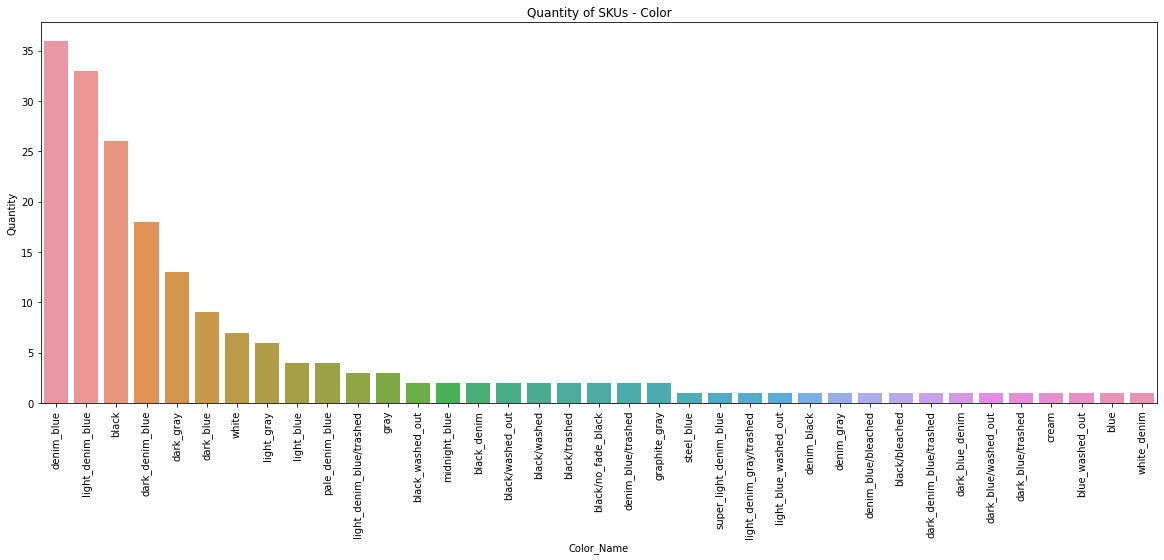

FIT:
+----+-------------+------------+--------------+
|    | Fit         |   Quantity |   Percentage |
|----+-------------+------------+--------------|
|  4 | slim_fit    |         71 |        36.22 |
|  3 | skinny_fit  |         53 |        27.04 |
|  1 | regular_fit |         44 |        22.45 |
|  2 | relaxed_fit |         23 |        11.73 |
|  0 | loose_fit   |          5 |         2.55 |
+----+-------------+------------+--------------+


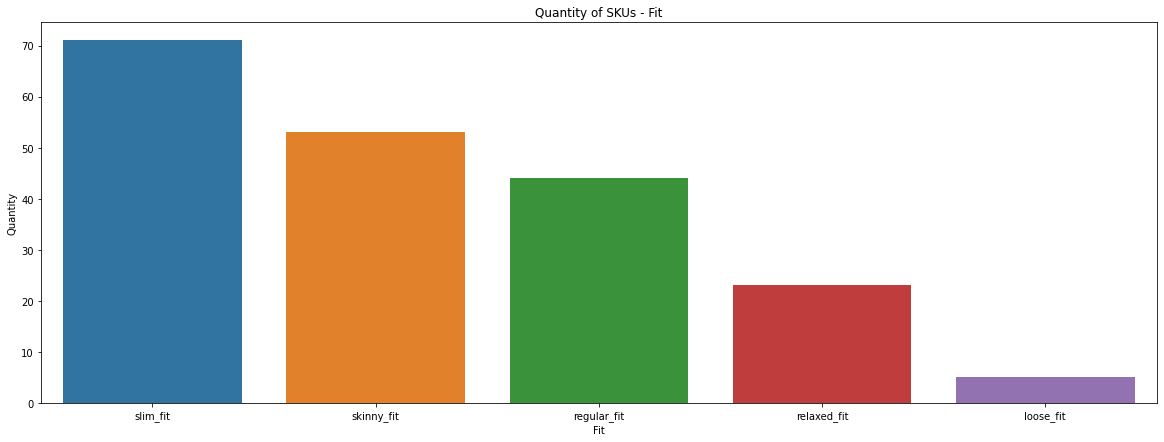

COMPOSITION:
+----+------------+--------------------+--------------------------+---------+--------+
|    | Material   |   Contain material |   Don`t contain material |   Yes % |   No % |
|----+------------+--------------------+--------------------------+---------+--------|
|  0 | cotton     |                196 |                        0 |  100    |   0    |
|  1 | polyester  |                 63 |                      133 |   32.14 |  67.86 |
|  2 | Spandex    |                110 |                      133 |   45.27 |  54.73 |
+----+------------+--------------------+--------------------------+---------+--------+


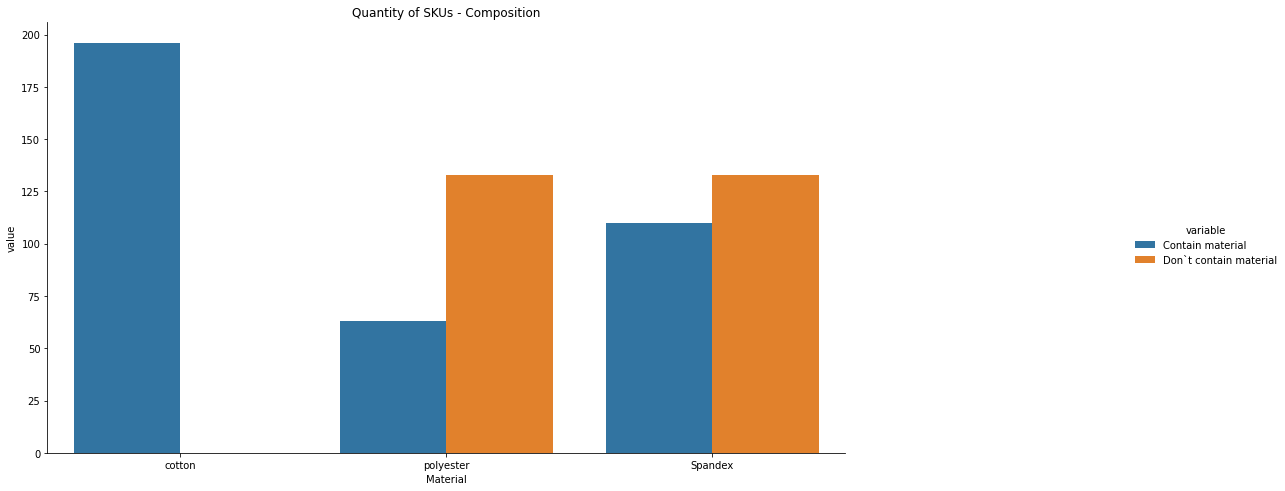

-------------------------------------------------------------------------------------------------------------------------------


						MEAN PRICE- COLOR, FIT, COMPOSITION



+----+--------------------------+------------+---------+
|    | Color_Name               |   Quantity |   Price |
|----+--------------------------+------------+---------|
| 19 | denim_blue               |         36 | 27.8789 |
| 27 | light_denim_blue         |         33 | 27.5355 |
|  0 | black                    |         26 | 27.0285 |
| 15 | dark_denim_blue          |         18 | 27.99   |
| 17 | dark_gray                |         13 | 22.8362 |
| 11 | dark_blue                |          9 | 24.3233 |
| 35 | white                    |          7 | 25.2757 |
| 30 | light_gray               |          6 | 29.6567 |
| 25 | light_blue               |          4 | 22.99   |
| 32 | pale_denim_blue          |          4 | 33.74   |
| 28 | light_denim_blue/trashed |          3 | 22.6567 |
| 24 | gray                

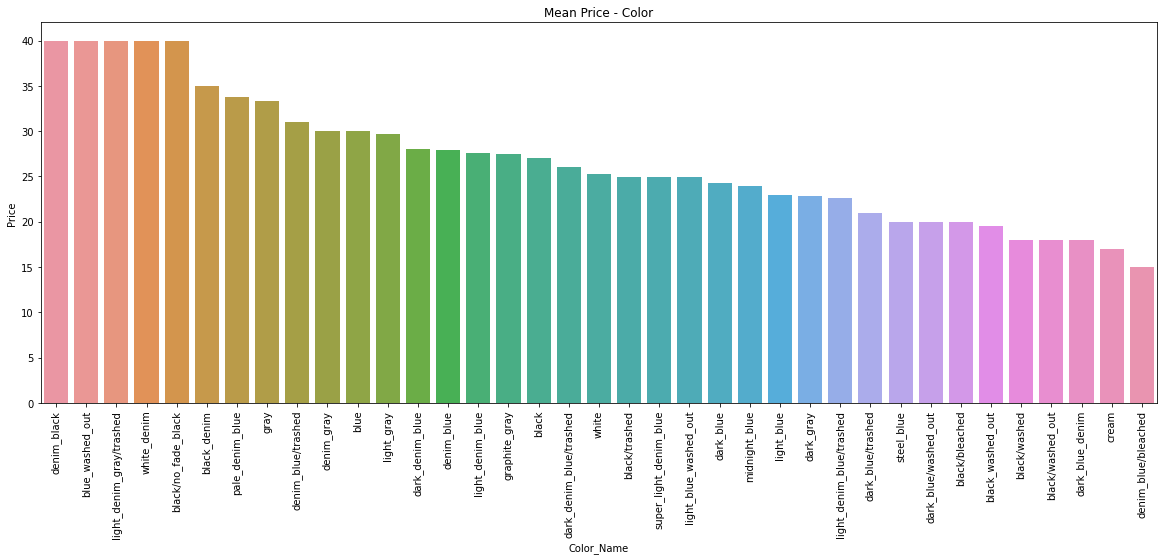

+----+-------------+------------+---------+
|    | Fit         |   Quantity |   Price |
|----+-------------+------------+---------|
|  0 | loose_fit   |          5 | 31.99   |
|  1 | regular_fit |         44 | 25.6945 |
|  2 | relaxed_fit |         23 | 28.3378 |
|  3 | skinny_fit  |         53 | 26.2353 |
|  4 | slim_fit    |         71 | 27.5252 |
+----+-------------+------------+---------+


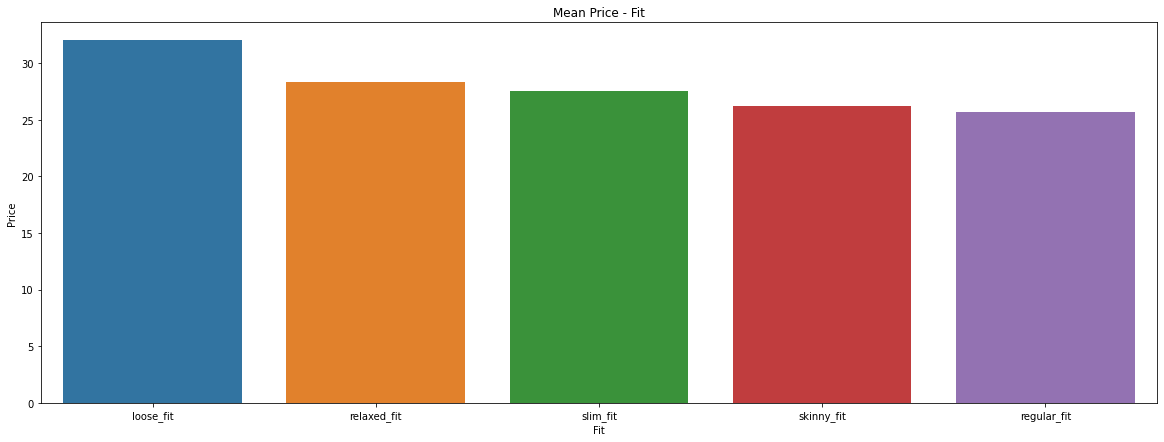

+----+------------+---------------------------------+---------------------------------------+
|    | Material   |   Contain material - Mean Price |   Don`t contain material - mean price |
|----+------------+---------------------------------+---------------------------------------|
|  0 | polyester  |                         26.9747 |                               26.9223 |
|  1 | Spandex    |                         26.9747 |                               30.2109 |
+----+------------+---------------------------------+---------------------------------------+


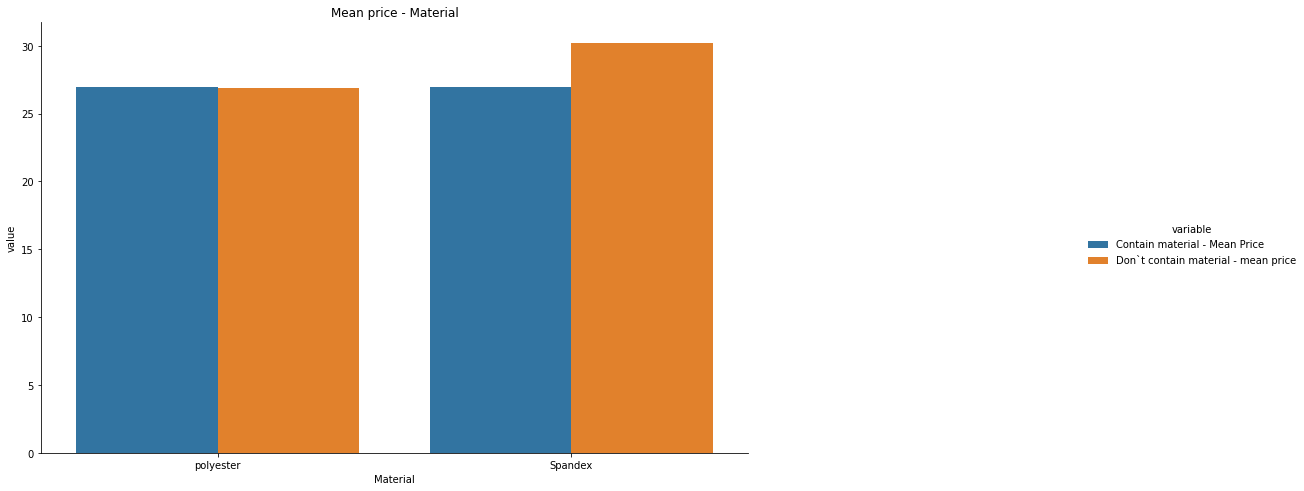

In [14]:
if __name__ == '__main__':
    
    #data collection
    df1 =database_connection ()
    #data cleaning
    df1 = cleaning (df1)
   
    #aux1
    aux1 = aux1()
    #data statistics
    df1 = statistics (df1)
    
    #aux2
    aux2 = aux2()
    #color ranking
    color_ranking = color_ranking(df1)
    #fit raking
    fit_ranking = fit_ranking(df1)
    #composition ranking
    composition_ranking = composition_ranking(df1)
    
    #aux3
    aux3 = aux3()
    #price_difference by colors
    price_dif_color = price_difference_colors(df1)
    #price difference by fit
    price_dif_fit = price_difference_fit(df1)
    #price difference by composition
    price_dif_composition = price_difference_composition(df1)